In [2]:
# load the packages needed
import numpy as np

import sys
if "../" not in sys.path:
  sys.path.append("../")
from src.solver import Solver
from src.model import AR, MA
from src.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

import src.data_processor as dp
import src.inference as inference
from src.ts_gen import ar1_gen

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


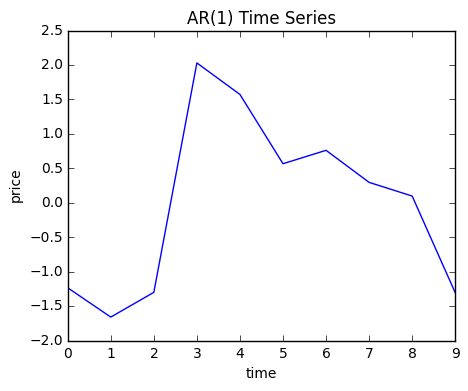

The estimated order is -1


IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
# generate a fake time series and plot it
from src.ts_gen import ar1_gen
Y = ar1_gen(0.5, sigma = 1.0, time = 10, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('AR(1) Time Series')
plt.show()

order_est = inference.ar_select(Y)
print("The estimated order is "+str(order_est))
param_est, var_est = inference.yule_walker(Y, order = order_est)
print(param_est, var_est)
acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of AR(1) Time Series')
plt.show()

print(acf_array)
test_stat, pval, test_result = inference.BL_stat(acf_array, order = 1, nobs = 10)
print(pval, test_result)

In [9]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(lag, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

In [4]:
# check whether the gradients are properly calculated
_, grads = AR_model.loss(Y)

# define a useful mathod for future use
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


d_phi = grads['phi']
d_intercept = grads['intercept']

d_sigma = grads['sigma']

d_phi_num = eval_numerical_gradient_array(lambda phi: AR_model.loss(Y, lag,phi,sigma,intercept)[0], phi, 1)
print 'd_phi error: ', rel_error(d_phi_num, d_phi)

d_intercept_num = eval_numerical_gradient_array(lambda intercept: AR_model.loss(Y, lag,phi,sigma,intercept)[0], intercept, 1)
print 'd_intercept error: ', rel_error(d_intercept_num, d_intercept)

d_sigma_num = eval_numerical_gradient_array(lambda sigma: AR_model.loss(Y, lag,phi,sigma,intercept)[0], sigma, 1)
print 'd_sigma error: ', rel_error(d_sigma_num, d_sigma)

d_phi error:  1.96849013717e-11
d_intercept error:  4.95789977516e-11
d_sigma error:  1.7393596443e-11


In [13]:
# use the Solver to solve the AR model
AR_solver = Solver(AR_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 1e-5,},
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver.train()
AR_model.params

3000
the loss is 348.085499
the loss is 342.455558
the loss is 336.712225
the loss is 330.886272
the loss is 325.021959
the loss is 319.180312
the loss is 313.442014
the loss is 307.908728
the loss is 302.700929
the loss is 297.949787
the loss is 293.781174
the loss is 290.292532
the loss is 287.528493
the loss is 285.465934
the loss is 284.018248
the loss is 283.059097
the loss is 282.454245
the loss is 282.086892
the loss is 281.869124
the loss is 281.741483
the loss is 281.666697
the loss is 281.622540
the loss is 281.596134
the loss is 281.580103


{'intercept': array([-0.03838932]),
 'phi': array([[ 0.46335039]]),
 'sigma': array([ 0.99908295])}

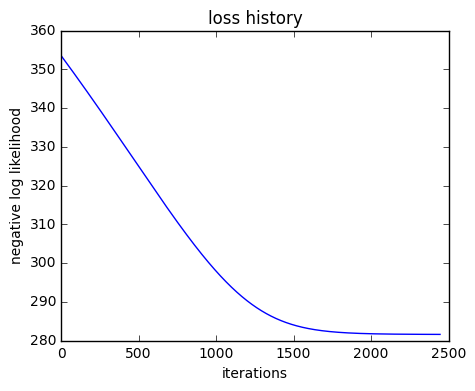

In [14]:
plt.plot(AR_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

In [7]:
# initialize the model
lag = 1
sigma = 2.0
intercept = 0.1
phi = np.random.randn(1, 1)
AR_model = AR(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

AR_solver_momentum = Solver(AR_model, Y,
                          update_rule='sgd_momentum',
                          optim_config={
                            'learning_rate': 1e-5,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
AR_solver_momentum.train()
AR_model.params

3000
the loss is 360.367048
the loss is 303.038408
the loss is 287.447062


{'intercept': array([ 0.00865851]),
 'phi': array([[ 0.41709862]]),
 'sigma': array([ 1.02529749])}

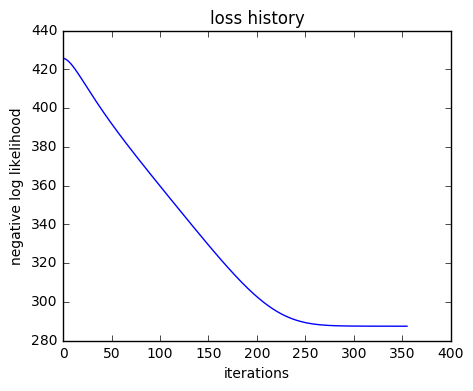

In [8]:
plt.plot(AR_solver_momentum.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

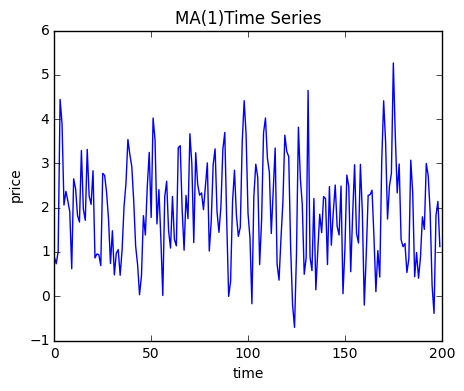

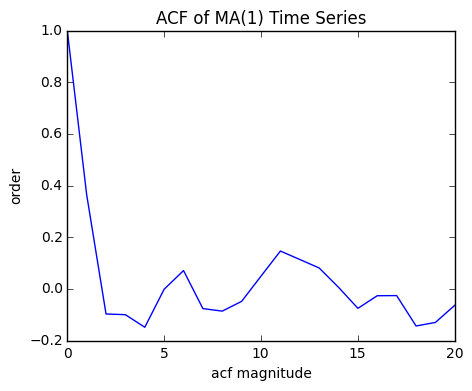

In [17]:
# generate a fake time series and plot it
from src.ts_gen import ma1_gen
Y = ma1_gen(0.5, constant = 2.0, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('MA(1)Time Series')
plt.show()

# add acf
acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of MA(1) Time Series')
plt.show()


In [15]:
# initialize the model
lag = 1
sigma = 1.1
intercept = 2.0
phi = np.random.randn(lag, 1)
MA_model = MA(lag=lag, phi=phi, sigma=sigma, intercept=intercept)

# check whether the gradients are properly calculated
_, grads = MA_model.loss(Y)
print grads
MA_solver = Solver(MA_model, Y,
                          update_rule='sgd',
                          optim_config={
                            'learning_rate': 3e-4,
                          },
                          
                          num_epochs=3000, batch_size=1,
                          print_every=100)
MA_solver.train()
MA_model.params

{'phi': array([[ 1718.64412781]]), 'intercept': array(0.0), 'sigma': array(-2153.4999858204174)}


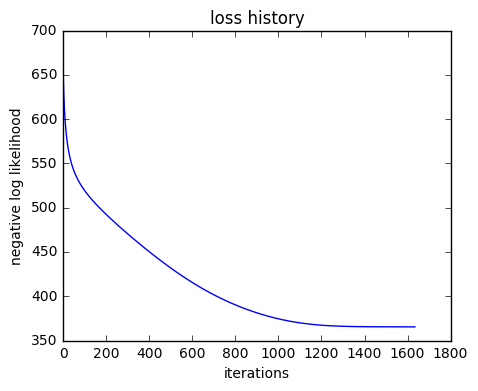

In [11]:
plt.plot(MA_solver.loss_history)
plt.xlabel('iterations')
plt.ylabel('negative log likelihood')
plt.title('loss history')
plt.show()

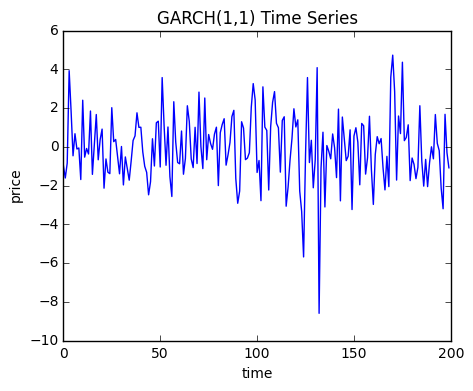

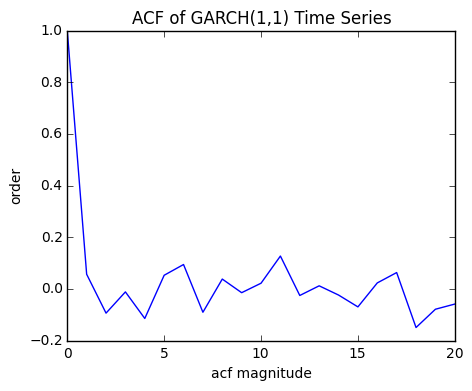

In [26]:
# generate a fake time series and plot it
from src.ts_gen import garch11_gen
Y = garch11_gen(a = 1.4, b = 0.6, c = 0.1, time = 200, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('GARCH(1,1) Time Series')
plt.show()


acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of GARCH(1,1) Time Series')
plt.show()

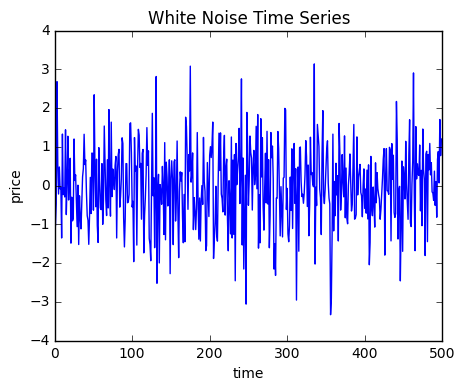

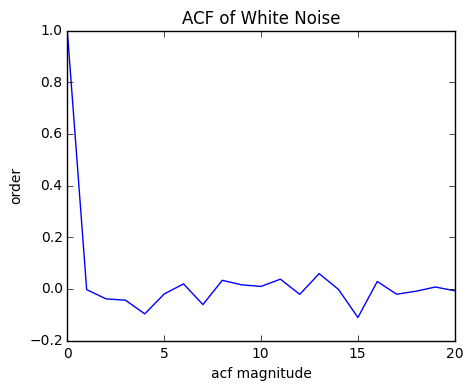

In [20]:
from src.ts_gen import ar1_gen
Y = ar1_gen(0, sigma = 1.0, time = 500, num = 1, burnin = 2000)
plt.plot(Y.T)
plt.xlabel('time')
plt.ylabel('price')
plt.title('White Noise Time Series')
plt.show()


acf_array = inference.acf(Y, nlags = 20)
plt.plot(acf_array)
plt.xlabel('acf magnitude')
plt.ylabel('order')
plt.title('ACF of White Noise ')
plt.show()